## Fix for Reproducibility

In [1]:
# check
#import os
#if os.environ.get("PYTHONHASHSEED") != "0":
#  raise Exception("You must set PYTHONHASHSEED=0 when starting the Jupyter server to get reproducible results.")

In [2]:
import numpy as np
import tensorflow as tf
import random as rn

# The below is necessary in Python 3.2.3 onwards to
# have reproducible behavior for certain hash-based operations.
# See these references for further details:
# https://docs.python.org/3.4/using/cmdline.html#envvar-PYTHONHASHSEED
# https://github.com/fchollet/keras/issues/2280#issuecomment-306959926

import os
os.environ['PYTHONHASHSEED'] = '0'

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
SEED=42
np.random.seed(SEED)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

rn.seed(SEED)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of
# non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from keras import backend as K

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.set_random_seed(SEED)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


In [3]:
from keras import __version__ as keras_version
print("keras version: {}".format(keras_version))
from tensorflow import __version__ as tf_version
print("tensorflow version:{}".format(tf_version ))

keras version: 2.2.4
tensorflow version:1.13.1


## Get Data and Generate Dataset

In [4]:
#!wget https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip
#!unzip data.zip

In [5]:
DATASET_PATH="/home/milhouse/datasets/steering_angle/data2"
!ls $DATASET_PATH

driving_log.csv  IMG


In [6]:
#import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as npimg
import os

## Keras
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense

import cv2
import pandas as pd
#import random
import ntpath

## Sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [7]:
## Store data
#datadir = 'self-driving-car-data-track-1'
datadir = DATASET_PATH
#columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'))
pd.set_option('display.max_colwidth', -1)
data.head()


,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
1,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236
2,IMG/center_2016_12_01_13_31_13_279.jpg,IMG/left_2016_12_01_13_31_13_279.jpg,IMG/right_2016_12_01_13_31_13_279.jpg,0.0,0.0,0.0,1.403993
3,IMG/center_2016_12_01_13_31_13_381.jpg,IMG/left_2016_12_01_13_31_13_381.jpg,IMG/right_2016_12_01_13_31_13_381.jpg,0.0,0.0,0.0,1.389892
4,IMG/center_2016_12_01_13_31_13_482.jpg,IMG/left_2016_12_01_13_31_13_482.jpg,IMG/right_2016_12_01_13_31_13_482.jpg,0.0,0.0,0.0,1.375934


In [8]:
def path_leaf(path):
  """Get tail of path"""
  head, tail = ntpath.split(path)
  return tail

## Remove path of images
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
print(data.shape)
data.head()

(8033, 7)


,center,left,right,steering,throttle,brake,speed
0,center_2016_12_01_13_31_13_037.jpg,left_2016_12_01_13_31_13_037.jpg,right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
1,center_2016_12_01_13_31_13_177.jpg,left_2016_12_01_13_31_13_177.jpg,right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236
2,center_2016_12_01_13_31_13_279.jpg,left_2016_12_01_13_31_13_279.jpg,right_2016_12_01_13_31_13_279.jpg,0.0,0.0,0.0,1.403993
3,center_2016_12_01_13_31_13_381.jpg,left_2016_12_01_13_31_13_381.jpg,right_2016_12_01_13_31_13_381.jpg,0.0,0.0,0.0,1.389892
4,center_2016_12_01_13_31_13_482.jpg,left_2016_12_01_13_31_13_482.jpg,right_2016_12_01_13_31_13_482.jpg,0.0,0.0,0.0,1.375934


In [9]:
def load_img_steering(datadir, df):
  """Get img and steering data into arrays"""
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)
  

In [10]:
## Split data into training and validation
X_train, X_valid, Y_train, Y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=0)


(6426, 160, 320, 3)


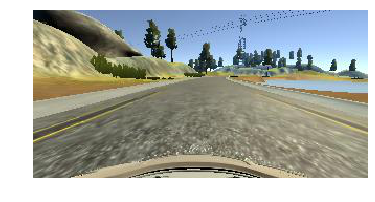

In [11]:
X_train = np.array(list(map(lambda x:npimg.imread(x), X_train)))
X_valid = np.array(list(map(lambda x:npimg.imread(x), X_valid)))
plt.imshow(X_train[rn.randint(0, len(X_train)-1)])
plt.axis('off')
print(X_train.shape)
IMG_SIZE = X_train[0].shape

## Nvidia convolutional network. First flavor 
https://github.com/tylerlum/self_driving_car

In [12]:
def nvidia_model_tylerlum():
  model = Sequential()
  model.add(Convolution2D(24, (5, 5), strides=(2, 2), input_shape=IMG_SIZE, activation='elu'))
  #model.add(Convolution2D(24, 5, 5, subsample=(2, 2), input_shape=(66, 200, 3), activation='elu'))
  model.add(Convolution2D(36, (5, 5), strides=(2, 2), activation='elu'))
  model.add(Convolution2D(48, (5, 5), strides=(2, 2), activation='elu'))
  model.add(Convolution2D(64, (3, 3), activation='elu'))
  model.add(Convolution2D(64, (3, 3), activation='elu'))
  model.add(Dropout(0.5))
  
  model.add(Flatten())
  
  model.add(Dense(100, activation='elu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(50, activation='elu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(10, activation='elu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(1))
  
  optimizer = Adam(lr=1e-3)
  model.compile(loss='mse', optimizer=optimizer)
  return model

In [13]:
model = nvidia_model_tylerlum()
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 78, 158, 24)       1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 77, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 17, 37, 48)        43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 35, 64)        27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 13, 33, 64)        36928     
_________________________________________________________________
dropout_1 (Dropout)  

In [14]:
np.random.seed(SEED)
history = model.fit(X_train, Y_train, epochs=30, validation_data=(X_valid, Y_valid), batch_size=100, verbose=1, shuffle=1)

Instructions for updating:
Use tf.cast instead.
Train on 6426 samples, validate on 1607 samples
Epoch 1/30
6426/6426 [==============================] - 148s 23ms/step - loss: 706585.9566 - val_loss: 0.9412
Epoch 2/30
6426/6426 [==============================] - 157s 24ms/step - loss: 4.4915 - val_loss: 0.9796
Epoch 3/30
6426/6426 [==============================] - 151s 24ms/step - loss: 4.4390 - val_loss: 1.0208
Epoch 4/30
6426/6426 [==============================] - 163s 25ms/step - loss: 4.4135 - val_loss: 1.0637
Epoch 5/30
6426/6426 [==============================] - 161s 25ms/step - loss: 4.0394 - val_loss: 1.1050
Epoch 6/30
6426/6426 [==============================] - 163s 25ms/step - loss: 4.0444 - val_loss: 1.1467
Epoch 7/30
6426/6426 [==============================] - 137s 21ms/step - loss: 3.9913 - val_loss: 1.1824
Epoch 8/30
6426/6426 [==============================] - 170s 26ms/step - loss: 3.9150 - val_loss: 1.2128
Epoch 9/30
6426/6426 [==============================] - 154

Text(0.5, 0, 'Epoch')

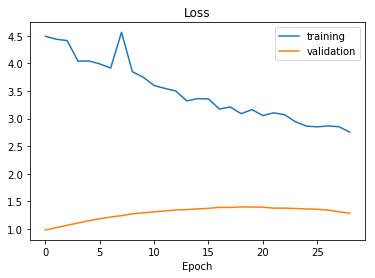

In [19]:
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

![Fry](https://www.meme-arsenal.com/memes/9f129bf6e96529d58871b5a4dccfd04a.jpg)

In [16]:
PROJECT_PATH="/home/milhouse/projects/car-behavioral-cloning/"

## Let's try on the simulator

In [17]:
model.save('{}/models/model_meetup.h5'.format(PROJECT_PATH))
!/home/milhouse/miniconda3/envs/car-behavioral-cloning-keras2/bin/python $PROJECT_PATH/drive_original.py $PROJECT_PATH/models/model_meetup.h5 $PROJECT_PATH/models/images_model_meetup & $PROJECT_PATH/beta_simulator_linux/beta_simulator.x86_64 

Found path: /home/milhouse/projects/car-behavioral-cloning//beta_simulator_linux/beta_simulator.x86_64
Mono path[0] = '/home/milhouse/projects/car-behavioral-cloning//beta_simulator_linux/beta_simulator_Data/Managed'
Mono path[1] = '/home/milhouse/projects/car-behavioral-cloning//beta_simulator_linux/beta_simulator_Data/Mono'
Mono config path = '/home/milhouse/projects/car-behavioral-cloning//beta_simulator_linux/beta_simulator_Data/Mono/etc'
displaymanager : xrandr version warning. 1.5
client has 4 screens
displaymanager screen (0)(eDP1): 1366 x 768
Using libudev for joystick management


Importing game controller configs
Using TensorFlow backend.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
2019-05-22 20:49:31.219653: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled

Steering angle: -1.12 and throttle: 1.99
Steering angle: -1.12 and throttle: 2.01
Steering angle: -1.12 and throttle: 2.03
Steering angle: -1.12 and throttle: 2.05
Steering angle: -1.12 and throttle: 2.07
Steering angle: -1.12 and throttle: 2.08
Steering angle: -1.12 and throttle: 2.10
Steering angle: -1.12 and throttle: 2.12
Steering angle: -1.12 and throttle: 2.14
Steering angle: -1.12 and throttle: 2.16
Steering angle: -1.12 and throttle: 2.17
Steering angle: -1.12 and throttle: 2.19
Steering angle: -1.12 and throttle: 2.21
Steering angle: -1.12 and throttle: 2.23
Steering angle: -1.12 and throttle: 2.25
Steering angle: -1.12 and throttle: 2.26
Steering angle: -1.12 and throttle: 2.28
Steering angle: -1.12 and throttle: 2.30
Steering angle: -1.12 and throttle: 2.32
Steering angle: -1.12 and throttle: 2.34
Steering angle: -1.12 and throttle: 2.35
Steering angle: -1.12 and throttle: 2.37
Steering angle: -1.12 and throttle: 2.39
Steering angle: -1.12 and throttle: 2.41
Steering angle: 

In [20]:
!convert $PROJECT_PATH/models/images_model_meetup/*5.jpg $PROJECT_PATH/models/images_model_tylerlum_zero.gif

<img src="../models/images_model_tylerlum_zero.gif" width="800">

## So...

![Lauda](https://media.giphy.com/media/pZsI3Q15AzN60/giphy.gif "lauda")